<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SV/5s/SV_fcn_extract_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import *

## Load model

In [61]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()

        self.cnn = nn.Sequential(
            nn.Linear(2*21,100),
            nn.ReLU(),
            nn.Linear(100,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,1)
        )

    def forward(self, x):
        out = x.reshape((x.size()[0], 1, 2*21))
        out = self.cnn(out)
        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [66]:
model = torch.load('SV_fcn_lonlat_5s.pt')
window = 21
variable = ('lon_std', 'lat_std')

# Test

In [67]:
data_test = pd.read_csv('./data/SV_test.csv')

resolution = 5
data_new = change_resolution(data_test, resolution)
data_new = standardize_data(data_new)

data_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_6_SV_T2,2008-11-25 21:03:25,-77.264393,-11.770143,0.0,0,15.618553,-4.458985,1.691276,0.797684,0.752478,0.996973,-0.077745
3,P1108_6_SV_T2,2008-11-25 21:03:30,-77.264937,-11.769742,0.0,0,14.841292,-22.123529,1.683857,0.802135,0.713763,0.926374,-0.376605
4,P1108_6_SV_T2,2008-11-25 21:03:35,-77.265407,-11.769267,0.0,0,14.722446,8.933298,1.677448,0.807408,0.707844,0.987870,0.155285
5,P1108_6_SV_T2,2008-11-25 21:03:40,-77.266028,-11.768765,0.0,0,17.552105,-6.364142,1.668979,0.812980,0.848787,0.993837,-0.110847
6,P1108_6_SV_T2,2008-11-25 21:03:45,-77.266380,-11.767972,0.0,0,19.248972,26.964911,1.664179,0.821782,0.933307,0.891284,0.453445


In [69]:
# create dataset for a trajectory
t = data_new[data_new.trip == 'P1108_6_SV_T2'].copy()    
test_set = TrajDataSet(t, window, variable, transforms.Compose([Center(), ToTensor()]))
weight = torch.FloatTensor([30])
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

# Test the model
list_out = []
list_loss = []
model.eval()
k = 0
with torch.no_grad():
    for (x, y, z) in test_set:

        # Run the forward pass
        out = model(x)
        loss = criterion(out.squeeze(1), z)

        list_loss.append(loss.item())
        list_out.append(1/(1+np.exp(-out.squeeze().numpy())))

(array([1.451e+03, 0.000e+00, 0.000e+00, 6.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.10287905,  4.20998044,  8.31708183, 12.42418323, 16.53128462,
        20.63838601, 24.7454874 , 28.8525888 , 32.95969019, 37.06679158,
        41.17389297]),
 <a list of 10 Patch objects>)

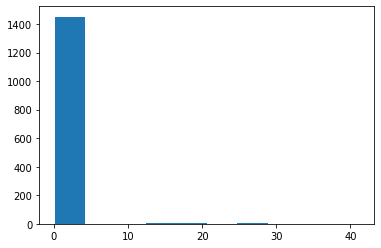

In [70]:
plt.hist(list_loss)

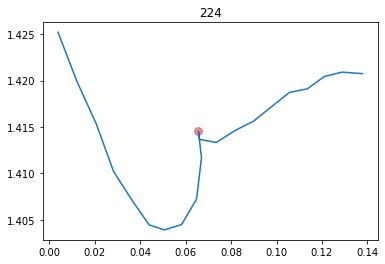

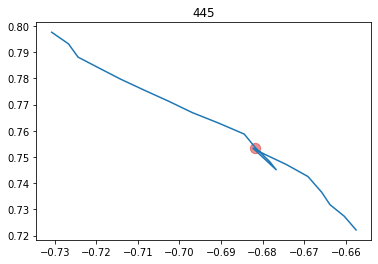

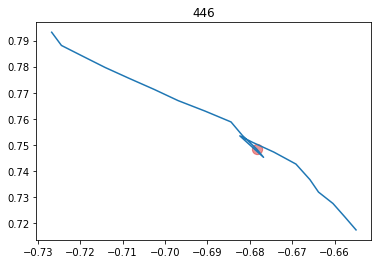

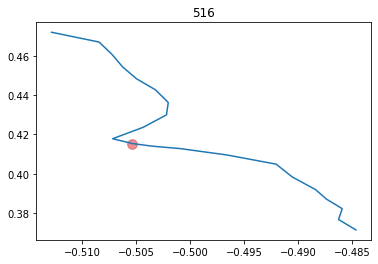

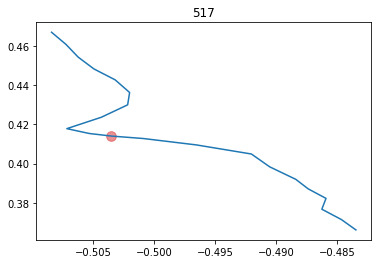

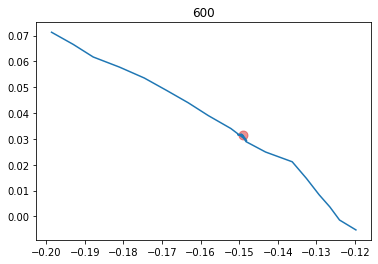

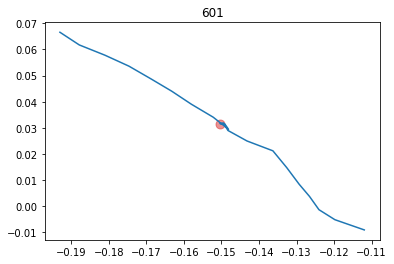

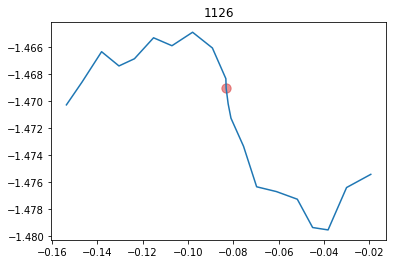

In [103]:
i = 0
for (x, y, z) in test_set:
    lon = x.squeeze().numpy()[0,:]
    lat = x.squeeze().numpy()[1,:]
    dive = z.squeeze().numpy()

    if (list_out[i]<0.5) & (dive>0) :

      col = '#d62728' if dive>0 else '#1f77b4'

      plt.figure()
      plt.plot(lon, lat)
      plt.scatter(lon[10], lat[10], s = 10 + 200*list_out[i], c = col, alpha = 0.5)
      plt.title(i)
      plt.show()

    i+=1

In [104]:
idx = [27,921, 517, 788]

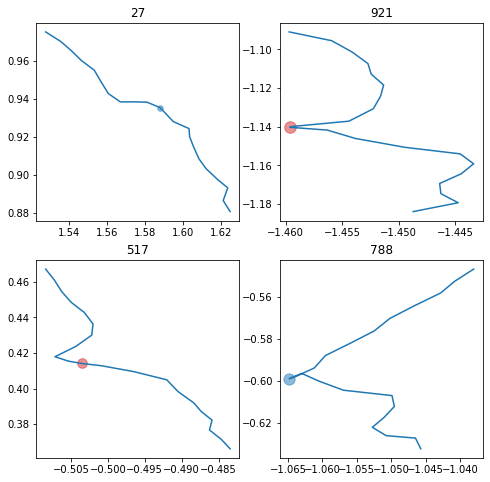

In [105]:
plt.figure(figsize = (8,8))

k = 1
for i in idx:

    x,y,z = test_set[i]
    
    lon = x.squeeze().numpy()[0,:]
    lat = x.squeeze().numpy()[1,:]
    dive = z.squeeze().numpy()

    col = '#d62728' if dive>0 else '#1f77b4'

    plt.subplot(2,2,k)
    plt.plot(lon, lat)
    plt.scatter(lon[10], lat[10], s = 10 + 200*list_out[i], c = col, alpha = 0.5)
    plt.title(i)

    k+=1

In [73]:
dive

False